In [1]:
import numpy as np
import pandas as pd
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier


def preprocessing():
    # Removes the dollar signs and commas
    def custom_dollar_converter(dollar_str):
        if '#' in dollar_str:
            return np.nan
        else:
            dollar_str = dollar_str.replace('$', '').replace(',', '')
            return float(dollar_str)
    
    # Determines whether a business is a franchise or not
    # If the value is 0 or 1, the business is not a franchise
    def custom_franchise_converter(franchise_str):
        if franchise_str.strip() == '0' or franchise_str.strip() == '1':
            return 0
        else:
            return 1
    
    # Trims zip codes to the first two numbers
    def zip_trimmer(zip_str):
        return zip_str[:2]
    
    # reads in data, using the custom converters
    bank_converters = {
        'DisbursementGross': custom_dollar_converter,
        'BalanceGross': custom_dollar_converter,
        'ChgOffPrinGr': custom_dollar_converter,
        'GrAppv': custom_dollar_converter,
        'SBA_Appv': custom_dollar_converter,
        'FranchiseCode': custom_franchise_converter,
        'Zip': zip_trimmer,
    }

    bank_parse_dates = [ 'ApprovalDate', 'ChgOffDate', 'DisbursementDate' ]

    df = pd.read_csv(
        'SBAnational.csv',
        converters=bank_converters,
        parse_dates=bank_parse_dates,
        date_parser=pd.to_datetime,
    )

    # drops unnecessary columns
    drop_columns = [
        'Name', 'City', 'ChgOffDate', 'DisbursementDate',
        'LoanNr_ChkDgt', 'Bank', 'NAICS',
        'CreateJob', 'RetainedJob', 'ChgOffPrinGr',
        'RevLineCr', 'LowDoc',
    ]
    working_df = df.drop(columns=drop_columns)
    
    # removes all null values
    working_df = working_df.dropna()
    
    
    # label encode MIS_Status
    mis_label_encoder = LabelEncoder()
    mis_encoded = mis_label_encoder.fit_transform(working_df['MIS_Status'])
    working_df['MIS_Status'] = mis_encoded
    
    
    # makes the NewExist variable more intuitive
    # a value of 1 means the business is new
    # a value of 0 means the business is not new
    working_df['NewExist'] = working_df['NewExist'].replace({ 2:1, 1:0 })
    # one hot encoding NewExist
    new_exist_true = working_df['NewExist'] == 1
    new_exist_false = working_df['NewExist'] == 0
    working_df['NewExistTrue'] = new_exist_true
    working_df['NewExistFalse'] = new_exist_false
    working_df = working_df.drop(columns=['NewExist'])
    

    # handling datetime information
    approval_date_months = working_df['ApprovalDate'].dt.month
    approval_date_days = working_df['ApprovalDate'].dt.day
    working_df['ApprovalMonth'] = approval_date_months
    working_df['ApprovalDay'] = approval_date_days
    working_df = working_df.drop(columns=['ApprovalDate'])

    approval_years = []
    for date in working_df['ApprovalFY']:
        if date == '1976A':
            approval_years.append(1976)
        else:
            approval_years.append(int(date))

    working_df['ApprovalFY'] = np.array(approval_years).astype(np.int64)
    
    
    # label encoding state information
    state_label_encoder = LabelEncoder()
    state_encoded = state_label_encoder.fit_transform(working_df['State'])
    bank_state_encoded = state_label_encoder.fit_transform(working_df['BankState'])
    working_df['State'] = state_encoded
    working_df['BankState'] = bank_state_encoded
    
    
    # converting zip information to the right datatype
    working_df['Zip'] = pd.to_numeric(working_df['Zip'])
    
    
    # separate data by features and target
    X = working_df.drop(columns=['MIS_Status'])
    y = working_df['MIS_Status']
    # separate the testing data from the training data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # balancing the training data based on MIS_Status
    sampler = RandomOverSampler(sampling_strategy='minority')
    df_without_status, df_with_status = X_train, y_train
    df_without_status_rebalanced, df_with_status_rebalanced = sampler.fit_resample(
        df_without_status, df_with_status
    )
    X_train, y_train = df_without_status_rebalanced, df_with_status_rebalanced
    
    
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocessing()

C:\Users\ztiff\AppData\Local\Temp\ipykernel_18584\3489471851.py:45: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
C:\Users\ztiff\AppData\Local\Temp\ipykernel_18584\3489471851.py:45: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\ztiff\AppData\Local\Temp\ipykernel_18584\3489471851.py:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
C:\Users\ztiff\AppData\Local\Temp\ipykernel_18584\3489471851.py:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 

In [2]:
model = CatBoostClassifier(iterations = 2, learning_rate= 1, depth = 2);
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0:	learn: 0.4909118	total: 238ms	remaining: 238ms
1:	learn: 0.4283433	total: 300ms	remaining: 0us


0.8515482797512032

In [ ]:

model = CatBoostClassifier(iterations = 9 , learning_rate = 0.1, depth = 6);
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0:	learn: 0.6417551	total: 121ms	remaining: 965ms
1:	learn: 0.6001338	total: 276ms	remaining: 967ms
2:	learn: 0.5653032	total: 481ms	remaining: 961ms
3:	learn: 0.5366426	total: 662ms	remaining: 827ms
4:	learn: 0.5090879	total: 844ms	remaining: 675ms
5:	learn: 0.4875136	total: 1.04s	remaining: 521ms
6:	learn: 0.4672581	total: 1.22s	remaining: 349ms
7:	learn: 0.4511044	total: 1.39s	remaining: 174ms
8:	learn: 0.4367958	total: 1.55s	remaining: 0us


0.8511797746535493

In [3]:
model = CatBoostClassifier(iterations = 500 , learning_rate = 0.1, depth = 6);
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0:	learn: 0.6170670	total: 189ms	remaining: 1m 34s
1:	learn: 0.5610997	total: 374ms	remaining: 1m 33s
2:	learn: 0.5166158	total: 571ms	remaining: 1m 34s
3:	learn: 0.4819982	total: 781ms	remaining: 1m 36s
4:	learn: 0.4541056	total: 975ms	remaining: 1m 36s
5:	learn: 0.4338607	total: 1.19s	remaining: 1m 37s
6:	learn: 0.4152685	total: 1.4s	remaining: 1m 38s
7:	learn: 0.4012997	total: 1.61s	remaining: 1m 39s
8:	learn: 0.3915621	total: 1.84s	remaining: 1m 40s
9:	learn: 0.3801712	total: 2.06s	remaining: 1m 40s
10:	learn: 0.3716851	total: 2.27s	remaining: 1m 40s
11:	learn: 0.3651752	total: 2.54s	remaining: 1m 43s
12:	learn: 0.3582513	total: 2.74s	remaining: 1m 42s
13:	learn: 0.3518877	total: 2.99s	remaining: 1m 43s
14:	learn: 0.3458457	total: 3.21s	remaining: 1m 43s
15:	learn: 0.3413383	total: 3.45s	remaining: 1m 44s
16:	learn: 0.3371186	total: 3.71s	remaining: 1m 45s
17:	learn: 0.3304016	total: 3.94s	remaining: 1m 45s
18:	learn: 0.3251904	total: 4.18s	remaining: 1m 45s
19:	learn: 0.3199523	to

0.9318879744503132

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


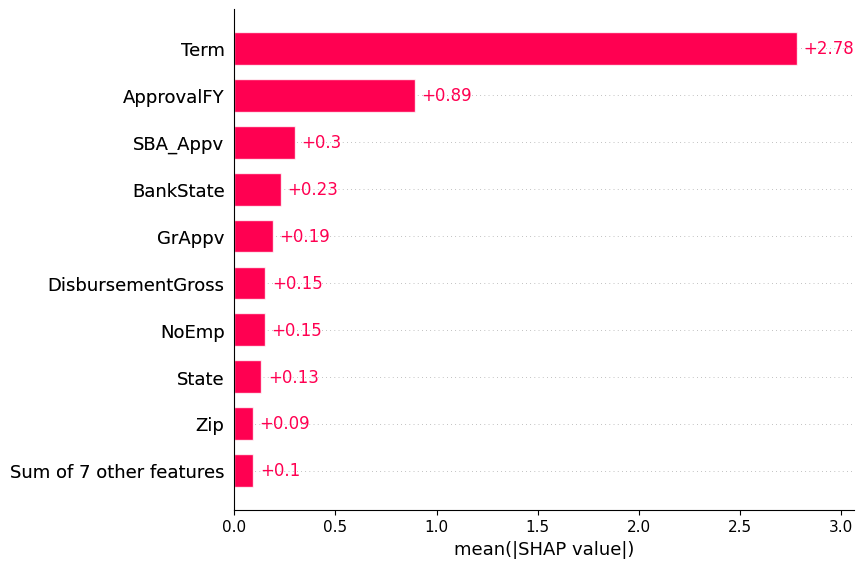

In [4]:
import shap
feature_names = list(X_test.columns)

# Calculate SHAP values for your test set
shap_values = shap.Explainer(model).shap_values(X_test)

# Create an Explanation object from the SHAP values with feature names
explanation = shap.Explanation(shap_values, X_test, feature_names=feature_names)

# Plot the SHAP values graph with feature names
shap.plots.bar(explanation)